In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 1. Membaca dan mempersiapkan data
file_path = '/content/drive/MyDrive/Robot Assembling/sensors/labeled/right/6011969_2024022300.csv'
data = pd.read_csv(file_path)

# Memeriksa kolom dan tipe data
print(data.dtypes)

# Menghapus kolom non-numerik
data = data.select_dtypes(include=[np.number])

# Memeriksa kembali kolom dan tipe data setelah penghapusan
print(data.dtypes)

timestamp      object
acc_x         float64
acc_y         float64
acc_z         float64
gyr_x         float64
gyr_y         float64
gyr_z         float64
video_time     object
label           int64
dtype: object
acc_x    float64
acc_y    float64
acc_z    float64
gyr_x    float64
gyr_y    float64
gyr_z    float64
label      int64
dtype: object


In [ ]:
data['label'].value_counts()

label
13    27833
2     22664
1     22166
14    21073
0     16204
17    15209
3     12825
10    11036
9     10936
4      7555
15     6560
11     5468
12     4870
5      4374
6      3878
16     3381
18     1590
8       796
Name: count, dtype: int64

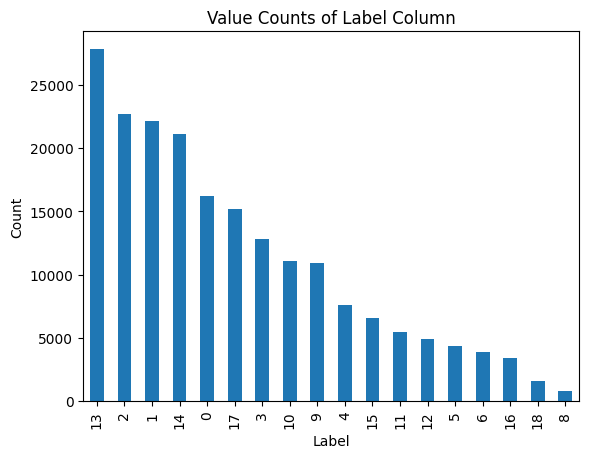

In [ ]:
import matplotlib.pyplot as plt

# Count the values in the 'label' column
value_counts = data['label'].value_counts()

# Create a bar chart
value_counts.plot(kind='bar')
plt.title('Value Counts of Label Column')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# Misalkan kolom terakhir adalah label
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Encoding label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=18)

# Normalisasi data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data untuk CNN (misal data 1D sensor dengan 1 channel)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Add, Activation, GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization

def resnet_block(input_tensor, filters, kernel_size=3, strides=1, activation='relu'):
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)

    return x

input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)
x = Conv1D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(2)(x)

x = resnet_block(x, 64)
x = resnet_block(x, 128)

x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(18, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 6, 64)                256       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 6, 64)                256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 6, 64)                0         ['batch_normalization[0][0

In [ ]:
# 4. Melatih model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Mengevaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/10
4961/4961 [==============================] - 65s 12ms/step - loss: 2.1362 - accuracy: 0.2942 - val_loss: 1.8756 - val_accuracy: 0.3615
Epoch 2/10
4961/4961 [==============================] - 58s 12ms/step - loss: 1.9327 - accuracy: 0.3452 - val_loss: 1.7567 - val_accuracy: 0.3948
Epoch 3/10
4961/4961 [==============================] - 59s 12ms/step - loss: 1.8358 - accuracy: 0.3740 - val_loss: 1.6643 - val_accuracy: 0.4234
Epoch 4/10
4961/4961 [==============================] - 59s 12ms/step - loss: 1.7582 - accuracy: 0.4007 - val_loss: 1.5740 - val_accuracy: 0.4574
Epoch 5/10
4961/4961 [==============================] - 54s 11ms/step - loss: 1.6950 - accuracy: 0.4208 - val_loss: 1.5110 - val_accuracy: 0.4770
Epoch 6/10
4961/4961 [==============================] - 55s 11ms/step - loss: 1.6417 - accuracy: 0.4389 - val_loss: 1.4848 - val_accuracy: 0.4836
Epoch 7/10
4961/4961 [==============================] - 63s 13ms/step - loss: 1.5895 - accuracy: 0.4552 - val_loss: 1.4095 -

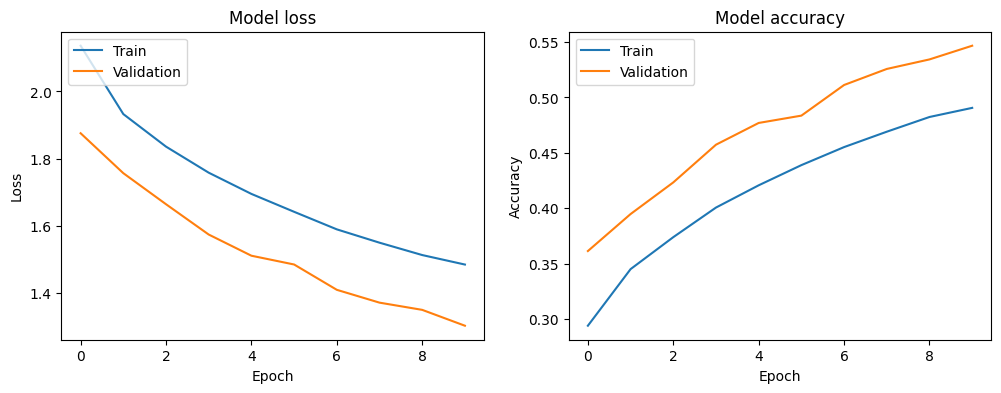

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Menyimpan model
model.save('sensor_classification_model.h5')

# Memuat model dan menggunakan untuk prediksi
loaded_model = tf.keras.models.load_model('sensor_classification_model.h5')
predictions = loaded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1241/1241 [==============================] - 4s 3ms/step


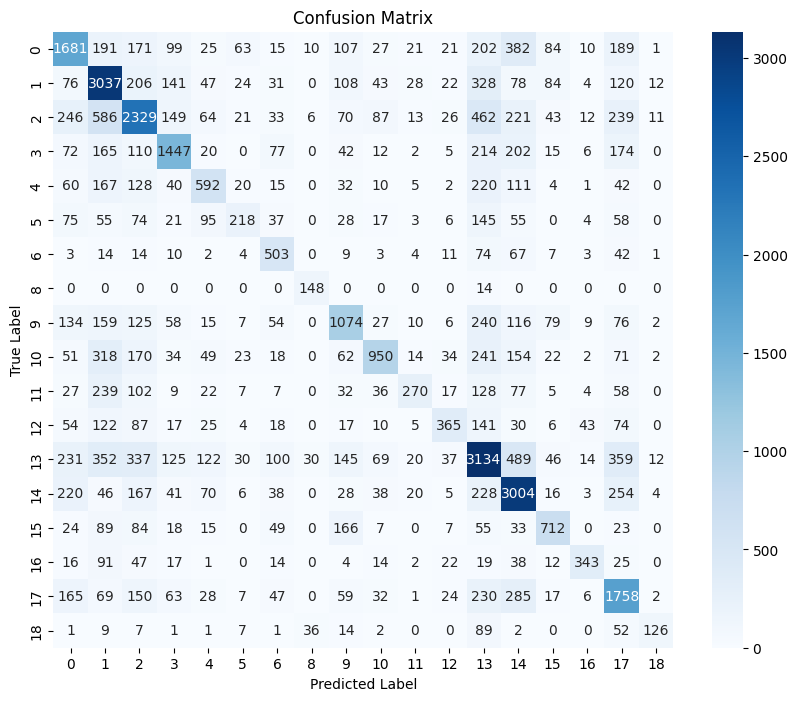

              precision    recall  f1-score   support

           0       0.54      0.51      0.52      3299
           1       0.53      0.69      0.60      4389
           2       0.54      0.50      0.52      4618
           3       0.63      0.56      0.60      2563
           4       0.50      0.41      0.45      1449
           5       0.49      0.24      0.33       891
           6       0.48      0.65      0.55       771
           8       0.64      0.91      0.76       162
           9       0.54      0.49      0.51      2191
          10       0.69      0.43      0.53      2215
          11       0.65      0.26      0.37      1040
          12       0.60      0.36      0.45      1018
          13       0.51      0.55      0.53      5652
          14       0.56      0.72      0.63      4188
          15       0.62      0.56      0.59      1282
          16       0.74      0.52      0.61       665
          17       0.49      0.60      0.54      2943
          18       0.73    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code)

# Assuming y_test is one-hot encoded, convert it to multiclass format
y_test_multiclass = np.argmax(y_test, axis=1)

# Convert predicted labels to integers for confusion matrix
predicted_labels = predicted_labels.astype(int)

conf_matrix = confusion_matrix(y_test_multiclass, predicted_labels)  # Use y_test_multiclass

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Convert label_encoder.classes_ to a list of strings for classification_report
class_names = label_encoder.classes_.astype(str).tolist()

# Menampilkan classification report
print(classification_report(y_test_multiclass, predicted_labels, target_names=class_names)) # Use y_test_multiclass

LSTM+Resnet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Add, Activation, GlobalAveragePooling1D, LSTM
from tensorflow.keras.layers import BatchNormalization

def resnet_block(input_tensor, filters, kernel_size=3, strides=1, activation='relu'):
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)

    return x

input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)
x = Conv1D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(2)(x)

x = resnet_block(x, 64)
x = resnet_block(x, 128)

x = LSTM(64, return_sequences=True)(x)  # LSTM layer
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(18, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                                  
 conv1d_7 (Conv1D)           (None, 6, 64)                256       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 6, 64)                256       ['conv1d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_5 (Activation)   (None, 6, 64)                0         ['batch_normalization_7[

In [ ]:
# 4. Melatih model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Mengevaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/10
4961/4961 [==============================] - 110s 19ms/step - loss: 2.0627 - accuracy: 0.3179 - val_loss: 1.7777 - val_accuracy: 0.3978
Epoch 2/10
4961/4961 [==============================] - 76s 15ms/step - loss: 1.8129 - accuracy: 0.3879 - val_loss: 1.6052 - val_accuracy: 0.4507
Epoch 3/10
4961/4961 [==============================] - 86s 17ms/step - loss: 1.6869 - accuracy: 0.4299 - val_loss: 1.5020 - val_accuracy: 0.4830
Epoch 4/10
4961/4961 [==============================] - 75s 15ms/step - loss: 1.5963 - accuracy: 0.4591 - val_loss: 1.4561 - val_accuracy: 0.4988
Epoch 5/10
4961/4961 [==============================] - 76s 15ms/step - loss: 1.5256 - accuracy: 0.4820 - val_loss: 1.3746 - val_accuracy: 0.5257
Epoch 6/10
4961/4961 [==============================] - 83s 17ms/step - loss: 1.4616 - accuracy: 0.5047 - val_loss: 1.2950 - val_accuracy: 0.5592
Epoch 7/10
4961/4961 [==============================] - 76s 15ms/step - loss: 1.4165 - accuracy: 0.5203 - val_loss: 1.2585 

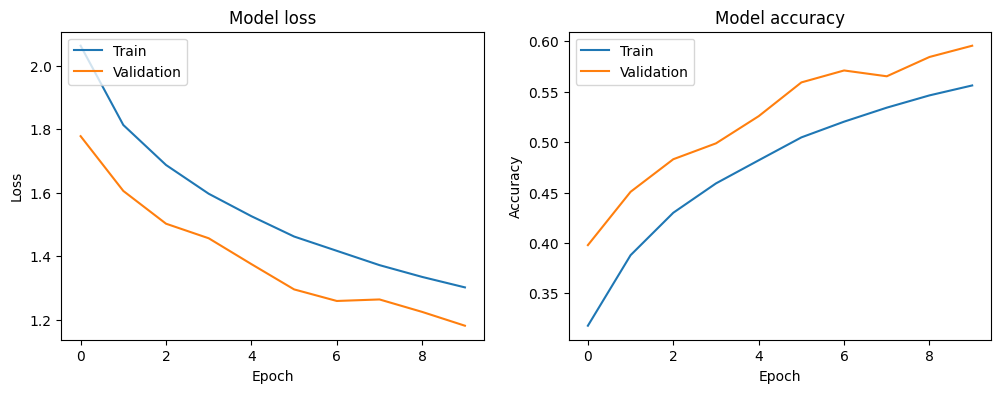

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


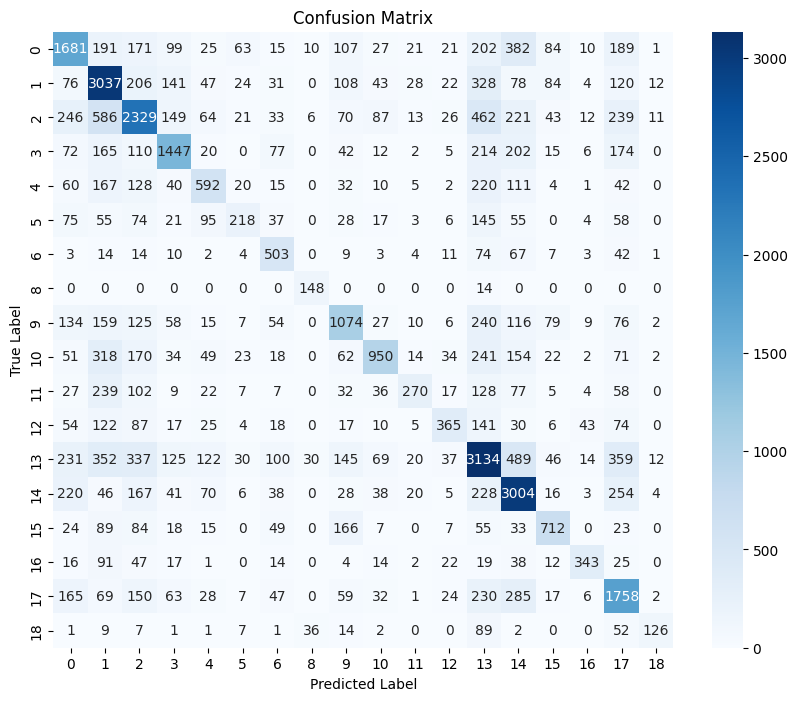

              precision    recall  f1-score   support

           0       0.54      0.51      0.52      3299
           1       0.53      0.69      0.60      4389
           2       0.54      0.50      0.52      4618
           3       0.63      0.56      0.60      2563
           4       0.50      0.41      0.45      1449
           5       0.49      0.24      0.33       891
           6       0.48      0.65      0.55       771
           8       0.64      0.91      0.76       162
           9       0.54      0.49      0.51      2191
          10       0.69      0.43      0.53      2215
          11       0.65      0.26      0.37      1040
          12       0.60      0.36      0.45      1018
          13       0.51      0.55      0.53      5652
          14       0.56      0.72      0.63      4188
          15       0.62      0.56      0.59      1282
          16       0.74      0.52      0.61       665
          17       0.49      0.60      0.54      2943
          18       0.73    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code)

# Assuming y_test is one-hot encoded, convert it to multiclass format
y_test_multiclass = np.argmax(y_test, axis=1)

# Convert predicted labels to integers for confusion matrix
predicted_labels = predicted_labels.astype(int)

conf_matrix = confusion_matrix(y_test_multiclass, predicted_labels)  # Use y_test_multiclass

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Convert label_encoder.classes_ to a list of strings for classification_report
class_names = label_encoder.classes_.astype(str).tolist()

# Menampilkan classification report
print(classification_report(y_test_multiclass, predicted_labels, target_names=class_names)) # Use y_test_multiclass

data oversampling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical



In [ ]:
# 1. Membaca dan mempersiapkan data
file_path = '/content/drive/MyDrive/Robot Assembling/sensors/labeled/right/6011969_2024022300.csv'
data = pd.read_csv(file_path)

# Memeriksa kolom dan tipe data
print(data.dtypes)

# Menghapus kolom non-numerik
data = data.select_dtypes(include=[np.number])

# Memeriksa kembali kolom dan tipe data setelah penghapusan
print(data.dtypes)

timestamp      object
acc_x         float64
acc_y         float64
acc_z         float64
gyr_x         float64
gyr_y         float64
gyr_z         float64
video_time     object
label           int64
dtype: object
acc_x    float64
acc_y    float64
acc_z    float64
gyr_x    float64
gyr_y    float64
gyr_z    float64
label      int64
dtype: object


In [ ]:
# Misalkan kolom terakhir adalah label
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Melakukan oversampling pada data training
smote = SMOTE(random_state=42)
X , y = smote.fit_resample(X, y)

In [ ]:
from collections import Counter

In [ ]:
data['label'].value_counts()

label
13    27833
2     22664
1     22166
14    21073
0     16204
17    15209
3     12825
10    11036
9     10936
4      7555
15     6560
11     5468
12     4870
5      4374
6      3878
16     3381
18     1590
8       796
Name: count, dtype: int64

In [ ]:
# Memeriksa jumlah data setelah oversampling
print(f"Setelah oversampling: {Counter(y)}")

Setelah oversampling: Counter({16: 27833, 17: 27833, 12: 27833, 0: 27833, 1: 27833, 11: 27833, 2: 27833, 13: 27833, 18: 27833, 10: 27833, 3: 27833, 5: 27833, 14: 27833, 4: 27833, 9: 27833, 6: 27833, 8: 27833, 15: 27833})


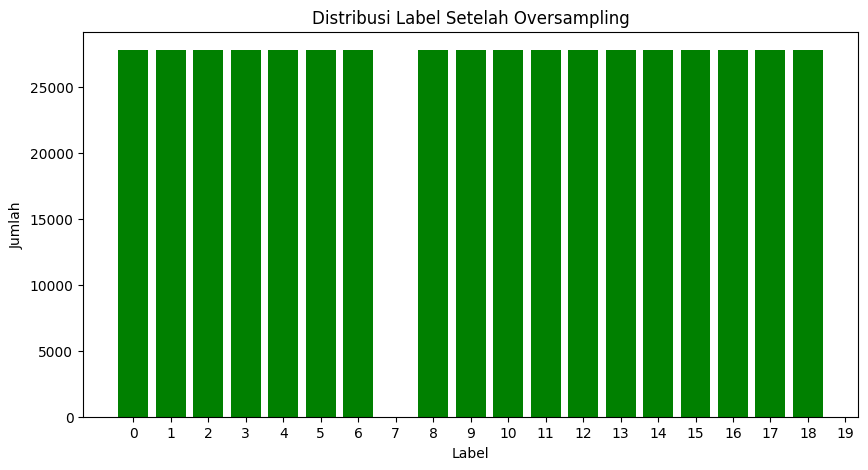

In [ ]:
# Visualisasi distribusi label setelah oversampling
counter_after = Counter(y)
plt.figure(figsize=(10, 5))
plt.bar(counter_after.keys(), counter_after.values(), color='green')
plt.title('Distribusi Label Setelah Oversampling')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(range(20))  # Menampilkan label pada sumbu x dari 0 sampai 19
plt.show()


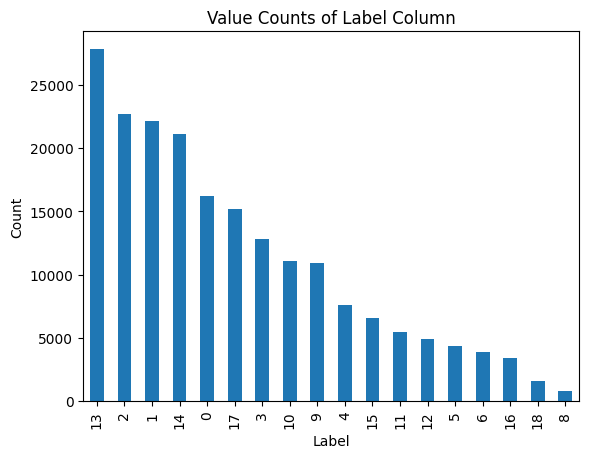

In [ ]:
import matplotlib.pyplot as plt

# Count the values in the 'label' column
value_counts = data['label'].value_counts()

# Create a bar chart
value_counts.plot(kind='bar')
plt.title('Value Counts of Label Column')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# Encoding label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=18)

# Normalisasi data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data untuk CNN (misal data 1D sensor dengan 1 channel)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Add, Activation, GlobalAveragePooling1D, LSTM
from tensorflow.keras.layers import BatchNormalization

def resnet_block(input_tensor, filters, kernel_size=3, strides=1, activation='relu'):
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)

    return x

input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)
x = Conv1D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(2)(x)

x = resnet_block(x, 64)
x = resnet_block(x, 128)

x = LSTM(64, return_sequences=True)(x)  # LSTM layer
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(18, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6, 1)]               0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 6, 64)                256       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 6, 64)                256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 6, 64)                0         ['batch_normalization[0][0

In [ ]:
# 4. Melatih model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Mengevaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/5
6263/6263 [==============================] - 141s 23ms/step - loss: 1.6995 - accuracy: 0.4604 - val_loss: 1.4235 - val_accuracy: 0.5373
Epoch 2/5
6263/6263 [==============================] - 137s 22ms/step - loss: 1.4496 - accuracy: 0.5395 - val_loss: 1.2567 - val_accuracy: 0.5939
Epoch 3/5
6263/6263 [==============================] - 138s 22ms/step - loss: 1.3289 - accuracy: 0.5775 - val_loss: 1.1624 - val_accuracy: 0.6226
Epoch 4/5
6263/6263 [==============================] - 133s 21ms/step - loss: 1.2515 - accuracy: 0.6016 - val_loss: 1.1126 - val_accuracy: 0.6407
Epoch 5/5
3132/3132 [==============================] - 23s 7ms/step - loss: 1.0553 - accuracy: 0.6601
Test Accuracy: 66.01%


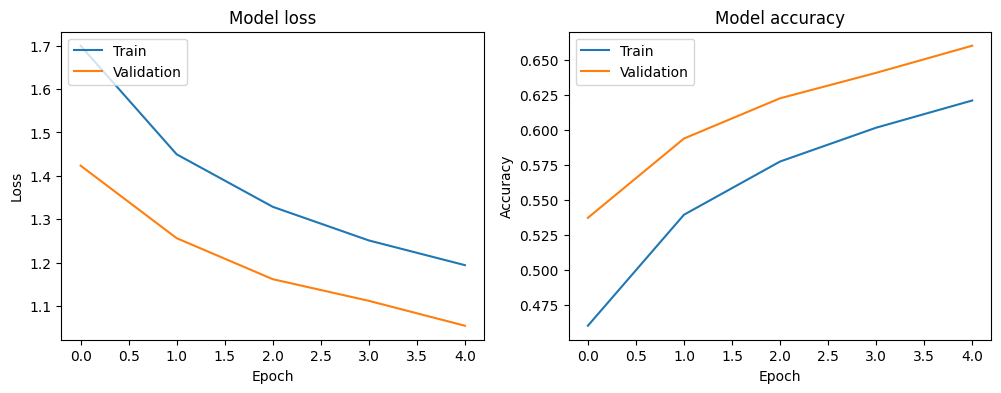

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Menyimpan model
model.save('sensor_classification_model_LSTM_Resnet.h5')

# Memuat model dan menggunakan untuk prediksi
loaded_model = tf.keras.models.load_model('sensor_classification_model_LSTM_Resnet.h5')
predictions = loaded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

3132/3132 [==============================] - 24s 7ms/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/sensor_classification_model_LSTM_Resnet.h5')

# Define the training data and labels
# X_train, y_train should be your training data and labels
# X_val, y_val should be your validation data and labels

# Example:
# X_train, y_train = ... # Load or define your training data and labels
# X_val, y_val = ...     # Load or define your validation data and labels

# Define callbacks
checkpoint = ModelCheckpoint('/content/sensor_classification_model_LSTM_Resnet.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1)

callbacks = [checkpoint, early_stopping]

# Continue training the model
history = loaded_model.fit(X_train, y_train,
                           epochs=10,
                           batch_size=64,
                           validation_data=(X_test, y_test),
                           callbacks=callbacks)




Epoch 1/10
6262/6263 [============================>.] - ETA: 0s - loss: 1.1489 - accuracy: 0.6338
Epoch 1: val_loss improved from inf to 1.03514, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 142s 22ms/step - loss: 1.1489 - accuracy: 0.6338 - val_loss: 1.0351 - val_accuracy: 0.6640
Epoch 2/10
   1/6263 [..............................] - ETA: 2:43 - loss: 0.9862 - accuracy: 0.7031

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6261/6263 [============================>.] - ETA: 0s - loss: 1.1142 - accuracy: 0.6453
Epoch 2: val_loss improved from 1.03514 to 0.98720, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 133s 21ms/step - loss: 1.1142 - accuracy: 0.6453 - val_loss: 0.9872 - val_accuracy: 0.6810
Epoch 3/10
6263/6263 [==============================] - ETA: 0s - loss: 1.0854 - accuracy: 0.6550
Epoch 3: val_loss improved from 0.98720 to 0.96903, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 127s 20ms/step - loss: 1.0854 - accuracy: 0.6550 - val_loss: 0.9690 - val_accuracy: 0.6848
Epoch 4/10
6261/6263 [============================>.] - ETA: 0s - loss: 1.0572 - accuracy: 0.6636
Epoch 4: val_loss improved from 0.96903 to 0.95218, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 131s 21ms/step - loss: 1.0572 - accuracy

NameError: name 'model' is not defined

In [ ]:
# Mengevaluasi model
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

3132/3132 [==============================] - 23s 7ms/step - loss: 0.8674 - accuracy: 0.7195
Test Accuracy: 71.95%


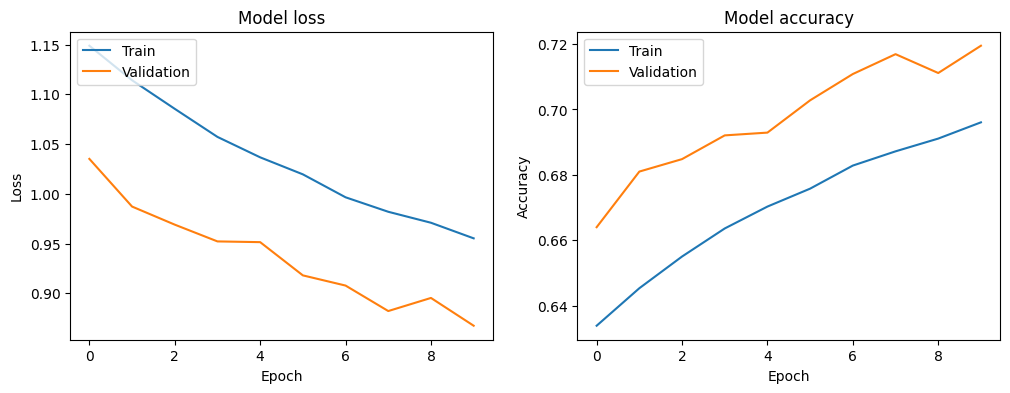

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Menyimpan model
loaded_model.save('sensor_classification_model_LSTM_Resnet_new.h5')

# Memuat model dan menggunakan untuk prediksi
loadeded_model = tf.keras.models.load_model('sensor_classification_model_LSTM_Resnet_new.h5')
predictions = loadeded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3132/3132 [==============================] - 19s 6ms/step


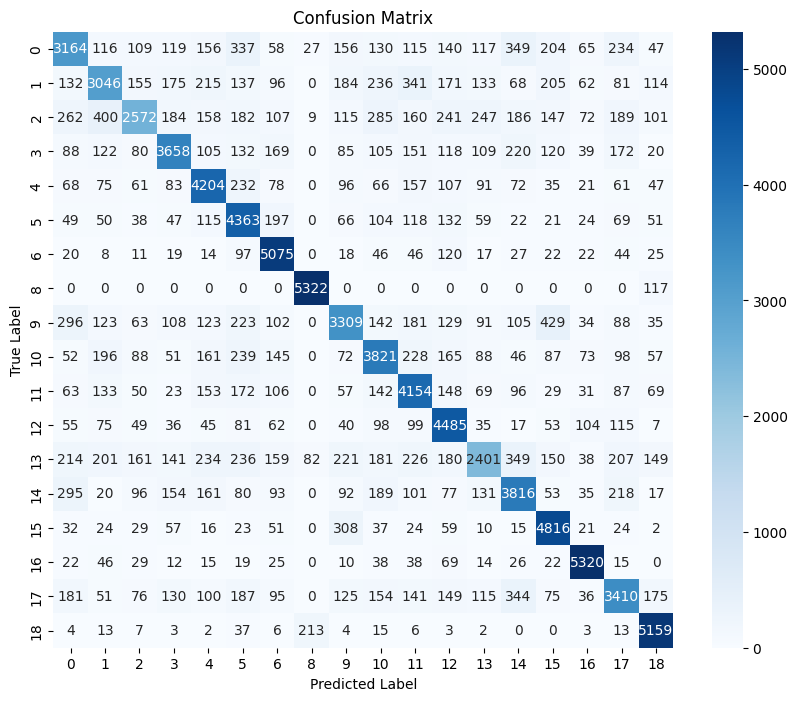

              precision    recall  f1-score   support

           0       0.63      0.56      0.59      5643
           1       0.65      0.55      0.59      5551
           2       0.70      0.46      0.55      5617
           3       0.73      0.67      0.70      5493
           4       0.70      0.76      0.73      5554
           5       0.64      0.79      0.71      5525
           6       0.77      0.90      0.83      5631
           8       0.94      0.98      0.96      5439
           9       0.67      0.59      0.63      5581
          10       0.66      0.67      0.67      5667
          11       0.66      0.74      0.70      5582
          12       0.69      0.82      0.75      5456
          13       0.64      0.43      0.52      5530
          14       0.66      0.68      0.67      5628
          15       0.74      0.87      0.80      5548
          16       0.89      0.93      0.91      5720
          17       0.67      0.62      0.64      5544
          18       0.83    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code)

# Assuming y_test is one-hot encoded, convert it to multiclass format
y_test_multiclass = np.argmax(y_test, axis=1)

# Convert predicted labels to integers for confusion matrix
predicted_labels = predicted_labels.astype(int)

conf_matrix = confusion_matrix(y_test_multiclass, predicted_labels)  # Use y_test_multiclass

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Convert label_encoder.classes_ to a list of strings for classification_report
class_names = label_encoder.classes_.astype(str).tolist()

# Menampilkan classification report
print(classification_report(y_test_multiclass, predicted_labels, target_names=class_names)) # Use y_test_multiclass

In [ ]:
# Memuat model dan menggunakan untuk prediksi
loadeded_model = tf.keras.models.load_model('sensor_classification_model_LSTM_Resnet_new.h5')
predictions = loadeded_model.predict(X_te)
predicted_labels = np.argmax(predictions, axis=1)

4195/4195 [==============================] - 19s 4ms/step


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code)

# Assuming y_test is one-hot encoded, convert it to multiclass format
y_test_multiclass = np.argmax(y_te, axis=1)

# Convert predicted labels to integers for confusion matrix
predicted_labels = predicted_labels.astype(int)

conf_matrix = confusion_matrix(y_test_multiclass, predicted_labels)  # Use y_test_multiclass

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Convert label_encoder.classes_ to a list of strings for classification_report
class_names = label_encoder.classes_.astype(str).tolist()

# Menampilkan classification report
print(classification_report(y_test_multiclass, predicted_labels, target_names=class_names)) # Use y_test_multiclass

AxisError: axis 1 is out of bounds for array of dimension 1

Before above

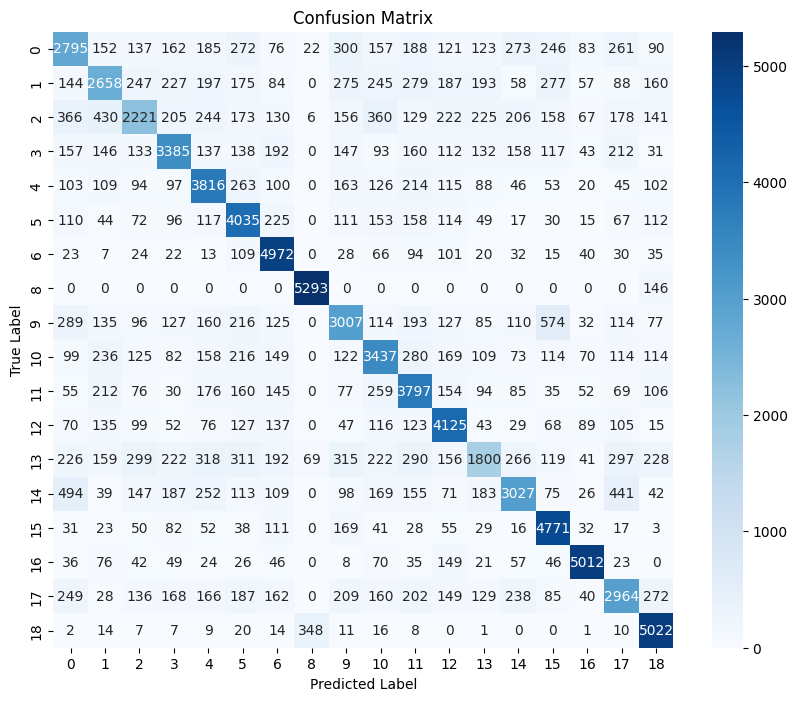

              precision    recall  f1-score   support

           0       0.53      0.50      0.51      5643
           1       0.58      0.48      0.52      5551
           2       0.55      0.40      0.46      5617
           3       0.65      0.62      0.63      5493
           4       0.63      0.69      0.65      5554
           5       0.61      0.73      0.67      5525
           6       0.71      0.88      0.79      5631
           8       0.92      0.97      0.95      5439
           9       0.57      0.54      0.56      5581
          10       0.59      0.61      0.60      5667
          11       0.60      0.68      0.64      5582
          12       0.67      0.76      0.71      5456
          13       0.54      0.33      0.41      5530
          14       0.65      0.54      0.59      5628
          15       0.70      0.86      0.77      5548
          16       0.88      0.88      0.88      5720
          17       0.59      0.53      0.56      5544
          18       0.75    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code)

# Assuming y_test is one-hot encoded, convert it to multiclass format
y_test_multiclass = np.argmax(y_test, axis=1)

# Convert predicted labels to integers for confusion matrix
predicted_labels = predicted_labels.astype(int)

conf_matrix = confusion_matrix(y_test_multiclass, predicted_labels)  # Use y_test_multiclass

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Convert label_encoder.classes_ to a list of strings for classification_report
class_names = label_encoder.classes_.astype(str).tolist()

# Menampilkan classification report
print(classification_report(y_test_multiclass, predicted_labels, target_names=class_names)) # Use y_test_multiclass

New Again

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/sensor_classification_model_LSTM_Resnet.h5')

# Define the training data and labels
# X_train, y_train should be your training data and labels
# X_val, y_val should be your validation data and labels

# Example:
# X_train, y_train = ... # Load or define your training data and labels
# X_val, y_val = ...     # Load or define your validation data and labels

# Define callbacks
checkpoint = ModelCheckpoint('/content/sensor_classification_model_LSTM_Resnet.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1)

callbacks = [checkpoint, early_stopping]

# Continue training the model
history = loaded_model.fit(X_train, y_train,
                           epochs=25,
                           batch_size=64,
                           validation_data=(X_test, y_test),
                           callbacks=callbacks)




Epoch 1/25
2479/2481 [============================>.] - ETA: 0s - loss: 1.3056 - accuracy: 0.5567
Epoch 1: val_loss improved from inf to 1.10725, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
2481/2481 [==============================] - 82s 31ms/step - loss: 1.3056 - accuracy: 0.5568 - val_loss: 1.1072 - val_accuracy: 0.6149
Epoch 2/25
   1/2481 [..............................] - ETA: 54s - loss: 1.1289 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2480/2481 [============================>.] - ETA: 0s - loss: 1.2293 - accuracy: 0.5821
Epoch 2: val_loss improved from 1.10725 to 1.09325, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
2481/2481 [==============================] - 66s 27ms/step - loss: 1.2293 - accuracy: 0.5821 - val_loss: 1.0933 - val_accuracy: 0.6197
Epoch 3/25
2480/2481 [============================>.] - ETA: 0s - loss: 1.1856 - accuracy: 0.5962
Epoch 3: val_loss improved from 1.09325 to 1.04395, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
2481/2481 [==============================] - 60s 24ms/step - loss: 1.1856 - accuracy: 0.5962 - val_loss: 1.0440 - val_accuracy: 0.6383
Epoch 4/25
2480/2481 [============================>.] - ETA: 0s - loss: 1.1514 - accuracy: 0.6072
Epoch 4: val_loss improved from 1.04395 to 1.03180, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
2481/2481 [==============================] - 70s 28ms/step - loss: 1.1514 - accuracy: 0

In [ ]:
# Menyimpan model
loaded_model.save('sensor_classification_model_LSTM_Resnet_new.h5')

In [ ]:
# Mengevaluasi model
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

1241/1241 [==============================] - 8s 7ms/step - loss: 0.8644 - accuracy: 0.7112
Test Accuracy: 71.12%


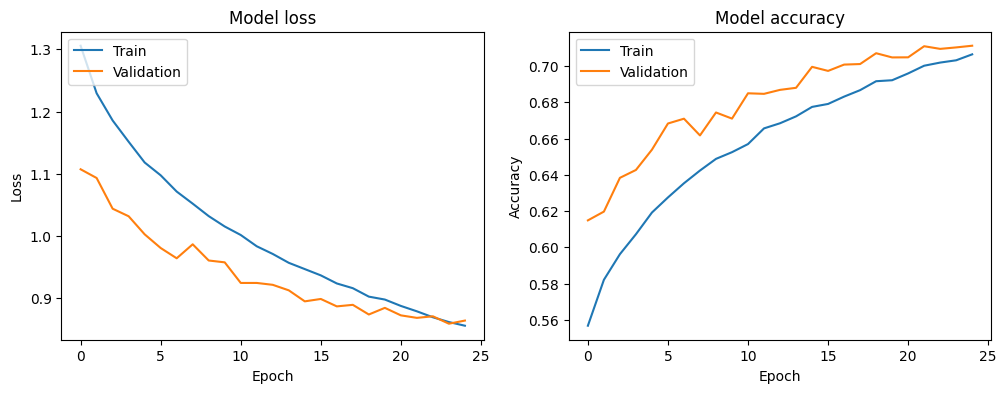

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Memuat model dan menggunakan untuk prediksi
loadeded_model = tf.keras.models.load_model('sensor_classification_model_LSTM_Resnet_new.h5')
predictions = loadeded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

1241/1241 [==============================] - 12s 9ms/step


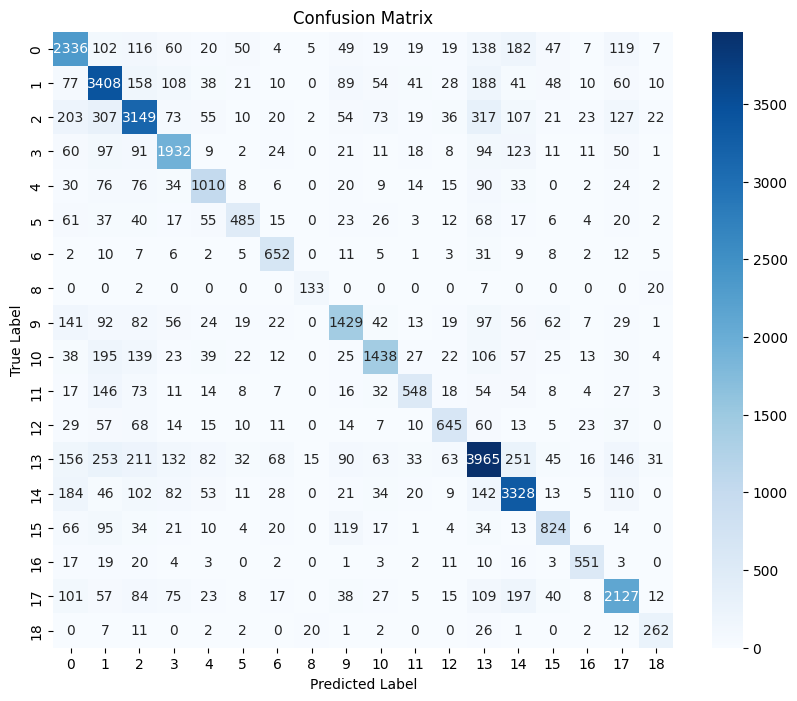

              precision    recall  f1-score   support

           0       0.66      0.71      0.69      3299
           1       0.68      0.78      0.73      4389
           2       0.71      0.68      0.69      4618
           3       0.73      0.75      0.74      2563
           4       0.69      0.70      0.70      1449
           5       0.70      0.54      0.61       891
           6       0.71      0.85      0.77       771
           8       0.76      0.82      0.79       162
           9       0.71      0.65      0.68      2191
          10       0.77      0.65      0.71      2215
          11       0.71      0.53      0.60      1040
          12       0.70      0.63      0.66      1018
          13       0.72      0.70      0.71      5652
          14       0.74      0.79      0.77      4188
          15       0.71      0.64      0.67      1282
          16       0.79      0.83      0.81       665
          17       0.72      0.72      0.72      2943
          18       0.69    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code)

# Assuming y_test is one-hot encoded, convert it to multiclass format
y_test_multiclass = np.argmax(y_test, axis=1)

# Convert predicted labels to integers for confusion matrix
predicted_labels = predicted_labels.astype(int)

conf_matrix = confusion_matrix(y_test_multiclass, predicted_labels)  # Use y_test_multiclass

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Convert label_encoder.classes_ to a list of strings for classification_report
class_names = label_encoder.classes_.astype(str).tolist()

# Menampilkan classification report
print(classification_report(y_test_multiclass, predicted_labels, target_names=class_names)) # Use y_test_multiclass

New

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/sensor_classification_model_LSTM_Resnet.h5')

# Define the training data and labels
# X_train, y_train should be your training data and labels
# X_val, y_val should be your validation data and labels

# Example:
# X_train, y_train = ... # Load or define your training data and labels
# X_val, y_val = ...     # Load or define your validation data and labels

# Define callbacks
checkpoint = ModelCheckpoint('/content/sensor_classification_model_LSTM_Resnet.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1)

callbacks = [checkpoint, early_stopping]

# Continue training the model
history = loaded_model.fit(X_train, y_train,
                           epochs=15,
                           batch_size=64,
                           validation_data=(X_test, y_test),
                           callbacks=callbacks)




Epoch 1/25
6260/6263 [============================>.] - ETA: 0s - loss: 1.1506 - accuracy: 0.6339
Epoch 1: val_loss improved from inf to 1.02227, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 147s 23ms/step - loss: 1.1506 - accuracy: 0.6339 - val_loss: 1.0223 - val_accuracy: 0.6677
Epoch 2/25
   5/6263 [..............................] - ETA: 1:31 - loss: 1.0969 - accuracy: 0.6531

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6262/6263 [============================>.] - ETA: 0s - loss: 1.1133 - accuracy: 0.6453
Epoch 2: val_loss improved from 1.02227 to 0.99099, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 120s 19ms/step - loss: 1.1133 - accuracy: 0.6453 - val_loss: 0.9910 - val_accuracy: 0.6796
Epoch 3/25
6263/6263 [==============================] - ETA: 0s - loss: 1.0825 - accuracy: 0.6558
Epoch 3: val_loss improved from 0.99099 to 0.96441, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 121s 19ms/step - loss: 1.0825 - accuracy: 0.6558 - val_loss: 0.9644 - val_accuracy: 0.6879
Epoch 4/25
6263/6263 [==============================] - ETA: 0s - loss: 1.0594 - accuracy: 0.6635
Epoch 4: val_loss improved from 0.96441 to 0.96212, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 123s 20ms/step - loss: 1.0594 - accuracy

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/sensor_classification_model_LSTM_Resnet.h5')

# Define the training data and labels
# X_train, y_train should be your training data and labels
# X_val, y_val should be your validation data and labels

# Example:
# X_train, y_train = ... # Load or define your training data and labels
# X_val, y_val = ...     # Load or define your validation data and labels

# Define callbacks
checkpoint = ModelCheckpoint('/content/sensor_classification_model_LSTM_Resnet.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1)

csv_logger = CSVLogger('training_log.csv', append=True)

callbacks = [checkpoint, early_stopping, csv_logger]

# Read the CSV log to determine the starting epoch
import pandas as pd
try:
    log_df = pd.read_csv('training_log.csv')
    initial_epoch = log_df['epoch'].iloc[-1] + 1
except FileNotFoundError:
    initial_epoch = 0

# Continue training the model
history = loaded_model.fit(X_train, y_train,
                           epochs=10,
                           initial_epoch=initial_epoch,
                           batch_size=64,
                           validation_data=(X_test, y_test),
                           callbacks=callbacks)




Epoch 1/10
6263/6263 [==============================] - ETA: 0s - loss: 1.1479 - accuracy: 0.6339
Epoch 1: val_loss improved from inf to 1.02892, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 179s 28ms/step - loss: 1.1479 - accuracy: 0.6339 - val_loss: 1.0289 - val_accuracy: 0.6687
Epoch 2/10
   5/6263 [..............................] - ETA: 1:37 - loss: 1.0598 - accuracy: 0.6594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6261/6263 [============================>.] - ETA: 0s - loss: 1.1113 - accuracy: 0.6465
Epoch 2: val_loss improved from 1.02892 to 1.00325, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 135s 22ms/step - loss: 1.1113 - accuracy: 0.6466 - val_loss: 1.0032 - val_accuracy: 0.6763
Epoch 3/10
6261/6263 [============================>.] - ETA: 0s - loss: 1.0828 - accuracy: 0.6552
Epoch 3: val_loss improved from 1.00325 to 0.99427, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 134s 21ms/step - loss: 1.0827 - accuracy: 0.6552 - val_loss: 0.9943 - val_accuracy: 0.6803
Epoch 4/10
6261/6263 [============================>.] - ETA: 0s - loss: 1.0560 - accuracy: 0.6641
Epoch 4: val_loss improved from 0.99427 to 0.95620, saving model to /content/sensor_classification_model_LSTM_Resnet.h5
6263/6263 [==============================] - 138s 22ms/step - loss: 1.0561 - accuracy

In [ ]:
# Menyimpan model
loaded_model.save('sensor_classification_model_LSTM_Resnet_new_fix.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Memuat model dan menggunakan untuk prediksi
loadeded_model = tf.keras.models.load_model('sensor_classification_model_LSTM_Resnet_new.h5')
predictions = loadeded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
# 1. Membaca dan mempersiapkan data
file_path = '/content/drive/MyDrive/Robot Assembling/sensors/labeled/right/6011969_2024022603.csv'
data = pd.read_csv(file_path)

# Menghapus kolom non-numerik
data = data.select_dtypes(include=[np.number])

# Misalkan kolom terakhir adalah label
X_te = data.iloc[:, :-1].values
y_te = data.iloc[:, -1].values

# Melakukan oversampling pada data training
smote = SMOTE(random_state=42)
X_test_over , y_test_over = smote.fit_resample(X_te, y_te)

# Encoding label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_test_over)
y = to_categorical(y, num_classes=19)

# Normalisasi data
scaler = StandardScaler()
X = scaler.fit_transform(X_test_over)

# Reshape data untuk CNN (misal data 1D sensor dengan 1 channel)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data menjadi training dan testing
X_te = X
y_te = y

In [ ]:
# Memuat model dan menggunakan untuk prediksi
loadeded_model = tf.keras.models.load_model('/content/sensor_classification_model_LSTM_Resnet_new_fix.h5')
predictions = loadeded_model.predict(X_te)
predicted_labels = np.argmax(predictions, axis=1)

10394/10394 [==============================] - 56s 5ms/step


In [ ]:
# Memuat model dan menggunakan untuk prediksi
loadeded_model = tf.keras.models.load_model('/content/sensor_classification_model_LSTM_Resnet_new_fix.h5')
predictions = loadeded_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

3132/3132 [==============================] - 28s 8ms/step


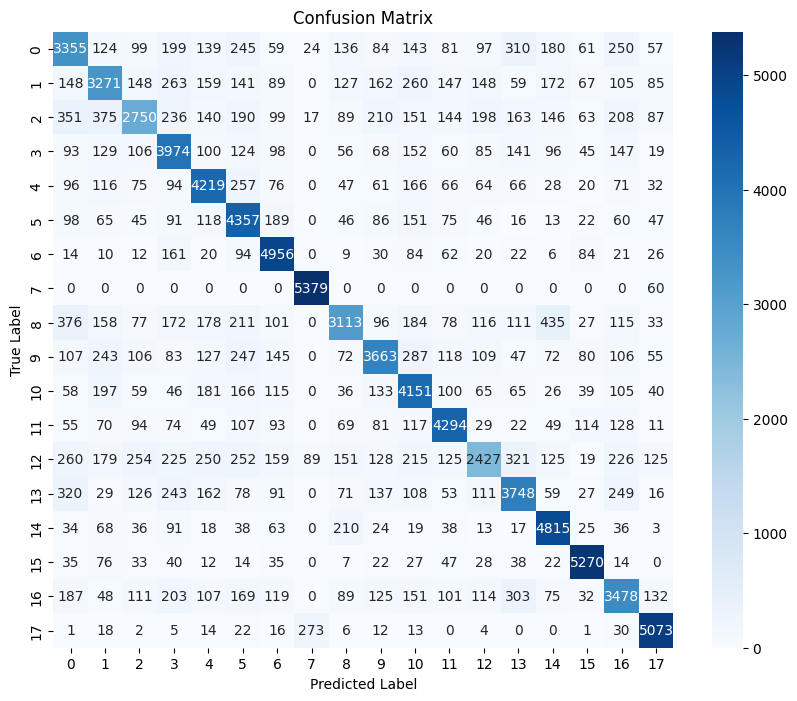

              precision    recall  f1-score   support

           0       0.60      0.59      0.60      5643
           1       0.63      0.59      0.61      5551
           2       0.67      0.49      0.56      5617
           3       0.64      0.72      0.68      5493
           4       0.70      0.76      0.73      5554
           5       0.65      0.79      0.71      5525
           6       0.76      0.88      0.82      5631
           7       0.93      0.99      0.96      5439
           8       0.72      0.56      0.63      5581
           9       0.72      0.65      0.68      5667
          10       0.65      0.74      0.69      5582
          11       0.77      0.79      0.78      5456
          12       0.66      0.44      0.53      5530
          13       0.69      0.67      0.68      5628
          14       0.76      0.87      0.81      5548
          15       0.88      0.92      0.90      5720
          16       0.65      0.63      0.64      5544
          17       0.86    

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code)

# Assuming y_test is one-hot encoded, convert it to multiclass format
y_test_multiclass = np.argmax(y_test, axis=1)

# Convert predicted labels to integers for confusion matrix
predicted_labels = predicted_labels.astype(int)

conf_matrix = confusion_matrix(y_test_multiclass, predicted_labels)  # Use y_test_multiclass

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(conf_matrix.shape[0]).astype(str), # Use number of classes as labels
            yticklabels=np.arange(conf_matrix.shape[0]).astype(str)) # Use number of classes as labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate class names based on the number of classes in confusion matrix
class_names = np.arange(conf_matrix.shape[0]).astype(str).tolist()

# Menampilkan classification report
print(classification_report(y_test_multiclass, predicted_labels, target_names=class_names)) # Use y_test_multiclass

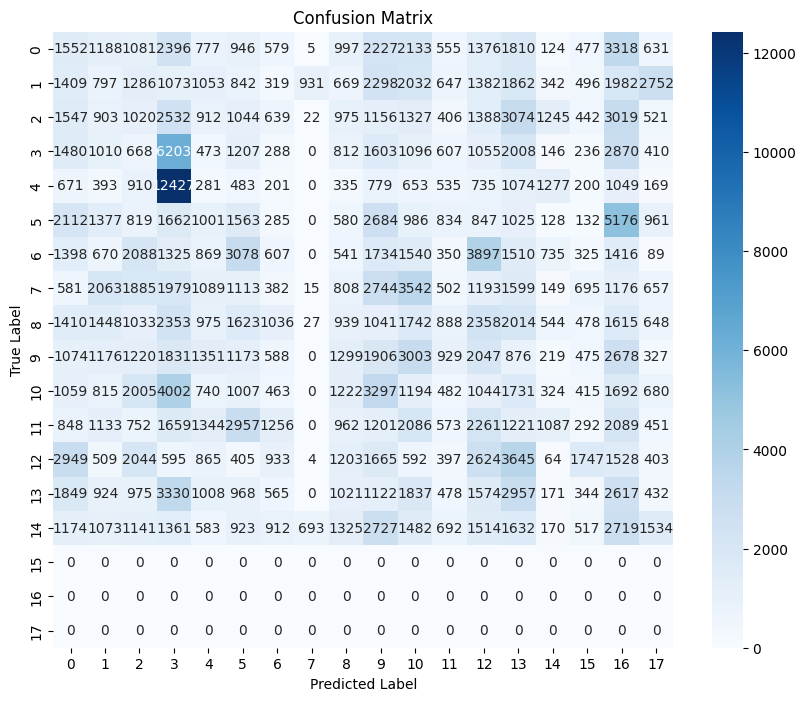

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.07      0.07      0.07     22172
           1       0.05      0.04      0.04     22172
           2       0.05      0.05      0.05     22172
           3       0.14      0.28      0.19     22172
           4       0.02      0.01      0.02     22172
           5       0.08      0.07      0.08     22172
           6       0.07      0.03      0.04     22172
           7       0.01      0.00      0.00     22172
           8       0.07      0.04      0.05     22172
           9       0.07      0.09      0.08     22172
          10       0.05      0.05      0.05     22172
          11       0.06      0.03      0.04     22172
          12       0.10      0.12      0.11     22172
          13       0.11      0.13      0.12     22172
          14       0.03      0.01      0.01     22172
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code)

# Assuming y_test is one-hot encoded, convert it to multiclass format
y_test_multiclass = np.argmax(y_te, axis=1)

# Convert predicted labels to integers for confusion matrix
predicted_labels = predicted_labels.astype(int)

conf_matrix = confusion_matrix(y_test_multiclass, predicted_labels)  # Use y_test_multiclass

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(conf_matrix.shape[0]).astype(str), # Use number of classes as labels
            yticklabels=np.arange(conf_matrix.shape[0]).astype(str)) # Use number of classes as labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate class names based on the number of classes in confusion matrix
class_names = np.arange(conf_matrix.shape[0]).astype(str).tolist()

# Menampilkan classification report
print(classification_report(y_test_multiclass, predicted_labels, target_names=class_names)) # Use y_test_multiclass

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import pandas as pd

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Robot Assembling/sensor_classification_model_LSTM_Resnet_new_fix.h5')

# Define the training data and labels
# X_train, y_train should be your training data and labels
# X_val, y_val should be your validation data and labels

# Example:
# X_train, y_train = ... # Load or define your training data and labels
# X_val, y_val = ...     # Load or define your validation data and labels

# Define callbacks
checkpoint = ModelCheckpoint('/content/sensor_classification_model_LSTM_Resnet_new_fix.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1)

csv_logger = CSVLogger('/content/training_log.csv', append=True)

callbacks = [checkpoint, early_stopping, csv_logger]

# Read the CSV log to determine the starting epoch
try:
    log_df = pd.read_csv('training_log.csv')
    initial_epoch = log_df['epoch'].max() + 1
except (FileNotFoundError, pd.errors.EmptyDataError):
    initial_epoch = 0

# Continue training the model
history = loaded_model.fit(X_train, y_train,
                           epochs=20,
                           initial_epoch=initial_epoch,
                           batch_size=64,
                           validation_data=(X_test, y_test),
                           callbacks=callbacks)


Epoch 11/20
6262/6263 [============================>.] - ETA: 0s - loss: 0.9468 - accuracy: 0.6988
Epoch 11: val_loss improved from inf to 0.85502, saving model to /content/sensor_classification_model_LSTM_Resnet_new_fix.h5
6263/6263 [==============================] - 171s 26ms/step - loss: 0.9469 - accuracy: 0.6988 - val_loss: 0.8550 - val_accuracy: 0.7260
Epoch 12/20
   1/6263 [..............................] - ETA: 2:28 - loss: 0.9010 - accuracy: 0.7812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6263/6263 [==============================] - ETA: 0s - loss: 0.9358 - accuracy: 0.7020
Epoch 12: val_loss improved from 0.85502 to 0.85128, saving model to /content/sensor_classification_model_LSTM_Resnet_new_fix.h5
6263/6263 [==============================] - 159s 25ms/step - loss: 0.9358 - accuracy: 0.7020 - val_loss: 0.8513 - val_accuracy: 0.7286
Epoch 13/20
6262/6263 [============================>.] - ETA: 0s - loss: 0.9220 - accuracy: 0.7059
Epoch 13: val_loss improved from 0.85128 to 0.84041, saving model to /content/sensor_classification_model_LSTM_Resnet_new_fix.h5
6263/6263 [==============================] - 167s 27ms/step - loss: 0.9220 - accuracy: 0.7059 - val_loss: 0.8404 - val_accuracy: 0.7300
Epoch 14/20
6262/6263 [============================>.] - ETA: 0s - loss: 0.9145 - accuracy: 0.7091
Epoch 14: val_loss improved from 0.84041 to 0.83365, saving model to /content/sensor_classification_model_LSTM_Resnet_new_fix.h5
6263/6263 [==============================] - 162s 26ms/s

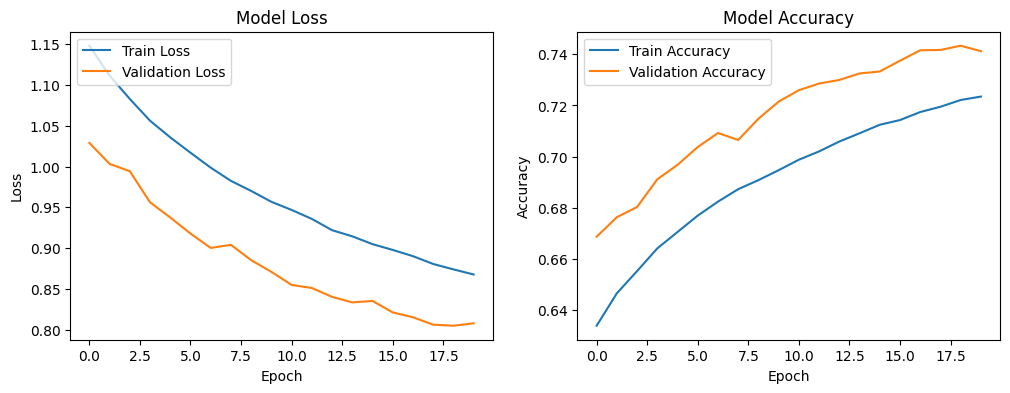

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the training log
log_df = pd.read_csv('/content/training_log.csv')

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(log_df['loss'], label='Train Loss')
plt.plot(log_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(log_df['accuracy'], label='Train Accuracy')
plt.plot(log_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.show()


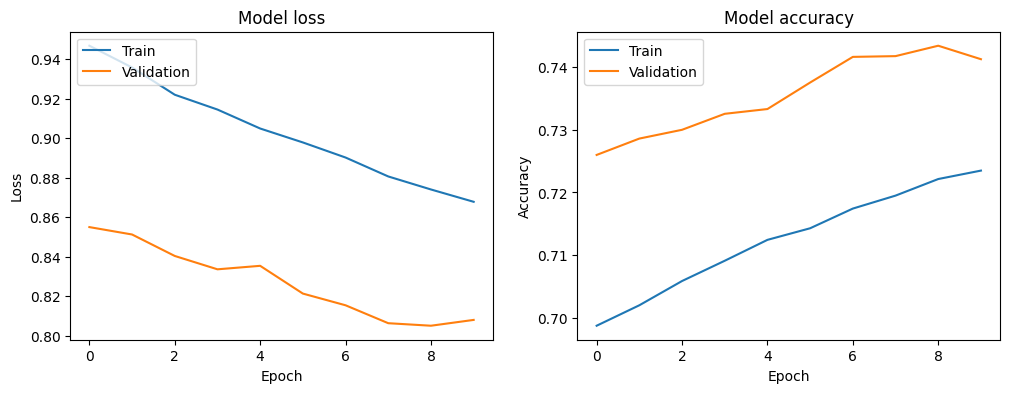

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Menyimpan model
loaded_model.save('sensor_classification_model_LSTM_Resnet_new_fixy.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
